# Pb scavenging parameterization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import modules.mapping_functions as mf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

In [3]:
colors = ['#f6c6bb', '#fa654a', '#e9bb65', '#78add6']

#### Load files

In [4]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [5]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'

dset = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons = dset['nav_lon'].values
ANHA4_lats = dset['nav_lat'].values
ANHA4_depths = dset['deptht'].values

dset_bio = xr.open_dataset(f'{folder_EPM101}ANHA4-EPM101_climatology_07.nc')
# biomass concentration in phosphate units [mol P/m3]
# biomass  = dset_bio['biomass_p'][:,0,:,:,:].mean(axis=0).values # calculate mean over the 12 months
biomass  = dset_bio['biomass_p'][0,:,:,:].values

In [7]:
dset_bio['biomass_p'].shape

(1, 50, 800, 544)

In [95]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202201/climatology.nc')
# based on same j dimensions, but longer i dimensions
ANHA12_lons = dset_ANHA12['nav_lon'][40:,:].values
ANHA12_lats = dset_ANHA12['nav_lat'][40:,:].values
# ANHA12_Mn   = dset_ANHA12['dissolmn'][:,0,:,40:,:].mean(axis=0).values # calculate mean over the 12 months
ANHA12_Mn   = dset_ANHA12['dissolmn'][7,0,:,40:,:].values # calculate mean over the 12 months

#### Functions:

In [49]:
def plot_residence_time(res_time, depth_slice=(0,18), maxv=1.0, savefig=False, filename='nan.png'):
    res_time_slice = np.mean(res_time[depth_slice[0]:depth_slice[1],:,:], axis=0)
    
    fig, ax1 = plt.subplots(1,1,figsize=(4.5, 3.74), dpi=300)

    proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax1)
    proj.drawcoastlines(color='#373736', linewidth=1.0);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    
    x, y = proj(mesh_lon, mesh_lat)
    proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth
    
    # Domain boundaries: 
    proj.plot(x[imin:1136,680]   , y[imin:1136,680]    , '-', c='k', lw=1.0, zorder=5); # southeastern Greenland
    proj.plot(x[imin,442:680]    , y[imin,442:680]     , '-', c='k', lw=1.0, zorder=5); # southern Baffin Bay
    proj.plot(x[imax,392:jmax]   , y[imax,392:jmax]  , '-', c='k', lw=1.0, zorder=5); # western Canada Basin
    proj.plot(x[1600:imax,jmax]  , y[1600:imax,jmax] , '-', c='k', lw=1.0, zorder=5); # northern Canada Basin
    proj.plot(x[1190:1474,292]   , y[1190:1474,292]    , '-', c='k', lw=1.0, zorder=5); # Hudson Bay bdy
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if depth_slice[0] < 17:
        x_kadko, y_kadko = proj(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj(chen_lons, chen_lats)
        CB = proj.scatter(x_kadko, y_kadko, c=kadko_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        proj.scatter(x_chen, y_chen, c=chen_res, s=30, edgecolor='w', zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        
        cbaxes1 = fig.add_axes([0.13, 0.17, 0.03, 0.23]) 
        CBar1 = plt.colorbar(CB, ax=ax1, cax=cbaxes1, orientation='vertical')
        CBar1.ax.tick_params(labelsize=6) 
        CBar1.set_label('Residence time [years]', fontsize=6)
        
    # Model residence time estimate:
    x_ANHA12, y_ANHA12 = proj(ANHA12_lons, ANHA12_lats)
#     CB2 = proj.contourf(x_ANHA12, y_ANHA12, res_time_slice, levels=np.linspace(0,maxv,21), cmap=cmocean.cm.matter, vmin=0, vmax=maxv, extend='both')

    CB2 = proj.pcolormesh(x_ANHA12, y_ANHA12, res_time_slice, cmap=cmocean.cm.matter, vmin=0, vmax=maxv)
        
    # Colorbar:
    cbaxes2 = fig.add_axes([0.25, 0.17, 0.03, 0.23]) 
    CBar2 = plt.colorbar(CB2, ax=ax1, cax=cbaxes2, orientation='vertical')
    CBar2.ax.tick_params(labelsize=6) 
    CBar2.set_label('Model residence time', fontsize=6)
    
    ax1.set_title(f'Depth slice: {depths[depth_slice[0]]:.0f}-{depths[depth_slice[1]]:.0f} m', fontsize=6)
    
    if savefig:
        fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb_chapter/{filename}', dpi=300, bbox_inches='tight')
    return

### Residence time estimates

Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp

In [10]:
# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

In [11]:
# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

In [13]:
kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, ANHA12_lons, ANHA12_lats) #find_index_ANHA12(kadko_lons, kadko_lats)
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, ANHA12_lons, ANHA12_lats) #find_index_ANHA12(chen_lons, chen_lats)

### Particle estimates:

In [14]:
ANHA12_biomass = np.empty((50,isize,jsize))
for depth in range(0,50):
    ANHA12_biomass[depth,:,:] = mf.interp_np_zero(ANHA4_lons.flatten(), ANHA4_lats.flatten(), \
                                                  biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)

In [96]:
# particles:
normalized_biogenic   = ANHA12_biomass/np.amax(ANHA12_biomass)
normalized_lithogenic = ANHA12_Mn/np.amax(ANHA12_Mn)

particle composition recipe: 
- $\beta$ --- lithogenic fraction
- $1-\beta$ --- biogenic fraction

In [97]:
betas     = np.linspace(0,1,40)
constants = np.linspace(1e-5,4e-2,20)
kadko_res_time_diff     = np.empty((len(kadko_res),len(constants),len(betas))); kadko_res_time_diff[:]     = np.nan;
kadko_modelled_res_time = np.empty((len(kadko_res),len(constants),len(betas))); kadko_modelled_res_time[:] = np.nan;
chen_res_time_diff      = np.empty((len(chen_res),len(constants),len(betas)));  chen_res_time_diff[:]      = np.nan;
chen_modelled_res_time  = np.empty((len(chen_res),len(constants),len(betas)));  chen_modelled_res_time[:]  = np.nan;

for ci,c in enumerate(constants):
    for bi, beta in enumerate(betas):
        # Residence time associated with these fractions
        res_time = c / ((1-beta)*normalized_biogenic + beta*normalized_lithogenic)

        # Difference between modeled and observed residence time at the stations:
        for n, stn in enumerate(zip(kadko_ANHA12_i, kadko_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                kadko_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                kadko_res_time_diff[n,ci,bi]     = kadko_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
        
        for n, stn in enumerate(zip(chen_ANHA12_i, chen_ANHA12_j)):
            if (~np.isnan(stn[0])) & (~np.isnan(stn[1])):
                stni = int(stn[0]); stnj = int(stn[1]);
                chen_modelled_res_time[n,ci,bi] = np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m
                chen_res_time_diff[n,ci,bi]     = chen_res[n] - np.mean(res_time[0:18,stni,stnj],axis=0) # mean over upper 50 m

In [98]:
kadko_res_time_diff_mean = np.nanmean(kadko_res_time_diff, axis=0)
kadko_res_time_rms       = np.sum(kadko_res_time_diff**2, axis=0)/len(kadko_res)

chen_res_time_diff_mean = np.nanmean(chen_res_time_diff, axis=0)
chen_res_time_rms       = np.sum(chen_res_time_diff**2, axis=0)/len(chen_res)

# Plots

Mean simulated biomass during period of sampling is normalized (biogenic particles) and combined with normalized Mn model field (lithogenic particles) as a measure of particle abundance. Then the particle abundance is inversely related to the residence time. Free parameters are: constant of inverse proportionality, fraction biogenic vs. lithogenic.

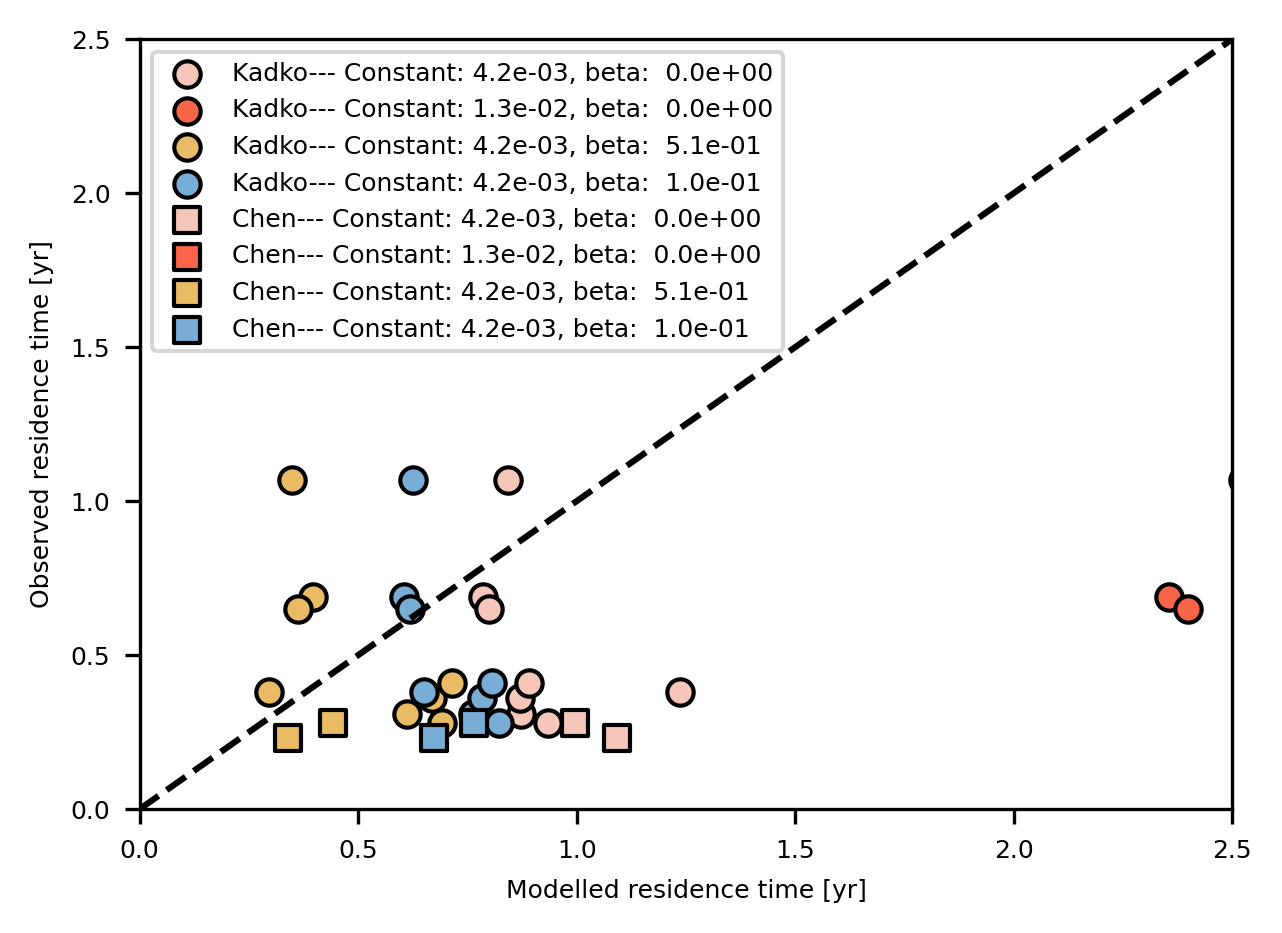

In [99]:
fig, ax = plt.subplots(1,1, figsize=(4.7,3.4), dpi=300)

ax.scatter(kadko_modelled_res_time[:,2,0],  kadko_res, color=colors[0], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,6,0],  kadko_res, color=colors[1], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[6]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,20], kadko_res, color=colors[2], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(kadko_modelled_res_time[:,2,4],  kadko_res, color=colors[3], s=40, edgecolor='k', \
           label=f'Kadko--- Constant: {constants[2]:.1e}, beta:  {betas[4]:.1e}')

ax.scatter(chen_modelled_res_time[:,2,0],  chen_res, marker='s', color=colors[0], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(chen_modelled_res_time[:,6,0],  chen_res, marker='s', color=colors[1], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[6]:.1e}, beta:  {betas[0]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,20], chen_res, marker='s', color=colors[2], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[20]:.1e}')
ax.scatter(chen_modelled_res_time[:,2,4],  chen_res, marker='s', color=colors[3], s=40, edgecolor='k', \
           label=f'Chen--- Constant: {constants[2]:.1e}, beta:  {betas[4]:.1e}')

ax.plot([0,3],[0,3], '--k')
ax.set_xlabel('Modelled residence time [yr]', fontsize=6)
ax.set_ylabel('Observed residence time [yr]', fontsize=6)
ax.set_xlim(0,2.5)
ax.set_ylim(0,2.5)
ax.tick_params(labelsize=6)
ax.legend(fontsize=6)

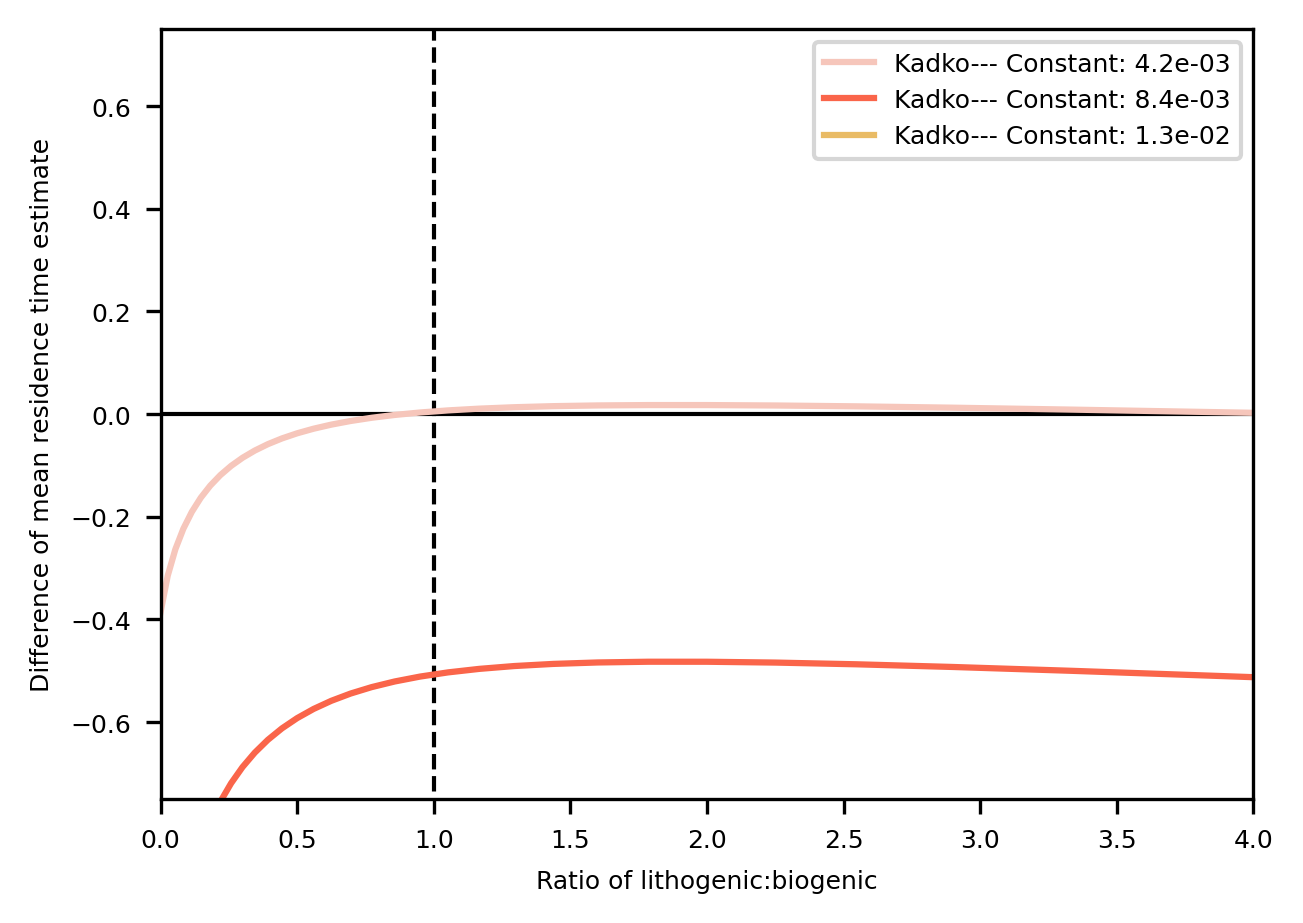

In [100]:
fig, ax = plt.subplots(1,1, figsize=(4.7,3.4), dpi=300)

ax.plot([1,1],[-2,2], '--k', linewidth=1.0)
ax.plot([0,5],[0,0], '-k', linewidth=1.0)
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[2,:],'-', color=colors[0], label=f'Kadko--- Constant: {constants[2]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[4,:],'-', color=colors[1], label=f'Kadko--- Constant: {constants[4]:.1e}')
ax.plot(betas/(1-betas), kadko_res_time_diff_mean[6,:],'-', color=colors[2], label=f'Kadko--- Constant: {constants[6]:.1e}')
ax.set_xlabel('Ratio of lithogenic:biogenic', fontsize=6)
ax.set_ylabel('Difference of mean residence time estimate', fontsize=6)
ax.set_xlim(0,4)
ax.set_ylim(-0.75,0.75)
ax.tick_params(labelsize=6)
ax.legend(fontsize=6)

In [101]:
cif, bif = np.meshgrid(constants, betas/(1-betas))

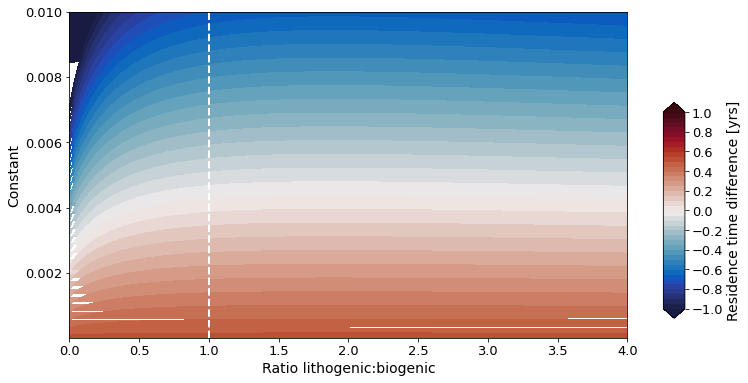

In [102]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

CB = ax.contourf(bif, cif, kadko_res_time_diff_mean.transpose(), \
                 levels=np.linspace(-1,1,41), cmap = cmocean.cm.balance, vmin=-1, vmax=1, extend='both')
ax.plot([1,1],[0,10],'--w', linewidth=2.0)
ax.set_xlabel('Ratio lithogenic:biogenic', fontsize=14)
ax.set_ylabel('Constant', fontsize=14)
ax.set_xlim(0,4)
ax.set_ylim(1e-5,1e-2)

# Colorbar:
ax.tick_params(labelsize=13)
cbaxes = fig.add_axes([0.95, 0.17, 0.03, 0.50]) 
CBar = plt.colorbar(CB, ax=ax, cax=cbaxes, orientation='vertical', ticks=np.arange(-1,1.2,0.2))
CBar.ax.tick_params(labelsize=13) 
CBar.set_label('Residence time difference [yrs]', fontsize=14)

In [103]:
# composition recipe:
def estimate_residence_time(beta, constant):
    particles = (1-beta)*normalized_biogenic + beta*normalized_lithogenic
    particles[particles <= 0] = np.nan
    particles[particles < 5e-5] = 5e-5 # no smaller
    
    modelled_res_time = constant / particles
    modelled_res_time[mesh_bathy[:,imin:imax,jmin:jmax] < 0.1] = np.nan ### uses old dimension coordinates
    return modelled_res_time

In [104]:
print(normalized_biogenic.shape)
print(normalized_lithogenic.shape)

(50, 1040, 640)
(50, 1040, 640)


In [105]:
modelled_res_time1 = estimate_residence_time(0.1, 4e-3)
modelled_res_time2 = estimate_residence_time(0.3, 6e-3)
modelled_res_time3 = estimate_residence_time(0.3, 4.2e-3)
modelled_res_time4 = estimate_residence_time(0.1, 5.2e-3)

In [106]:
print(f'Modelled residence time 1: {np.nanmin(modelled_res_time1):.2f}-{np.nanmax(modelled_res_time1):.2f}, mean: {np.nanmean(modelled_res_time1):.2f}')
print(f'Modelled residence time 2: {np.nanmin(modelled_res_time2):.2f}-{np.nanmax(modelled_res_time2):.2f}, mean: {np.nanmean(modelled_res_time2):.2f}')
print(f'Modelled residence time 3: {np.nanmin(modelled_res_time3):.2f}-{np.nanmax(modelled_res_time3):.2f}, mean: {np.nanmean(modelled_res_time3):.2f}')
print(f'Modelled residence time 4: {np.nanmin(modelled_res_time4):.2f}-{np.nanmax(modelled_res_time4):.2f}, mean: {np.nanmean(modelled_res_time4):.2f}')

Modelled residence time 1: 0.01-80.00, mean: 5.50
Modelled residence time 2: 0.01-120.00, mean: 3.09
Modelled residence time 3: 0.01-84.00, mean: 2.16
Modelled residence time 4: 0.01-104.00, mean: 7.15


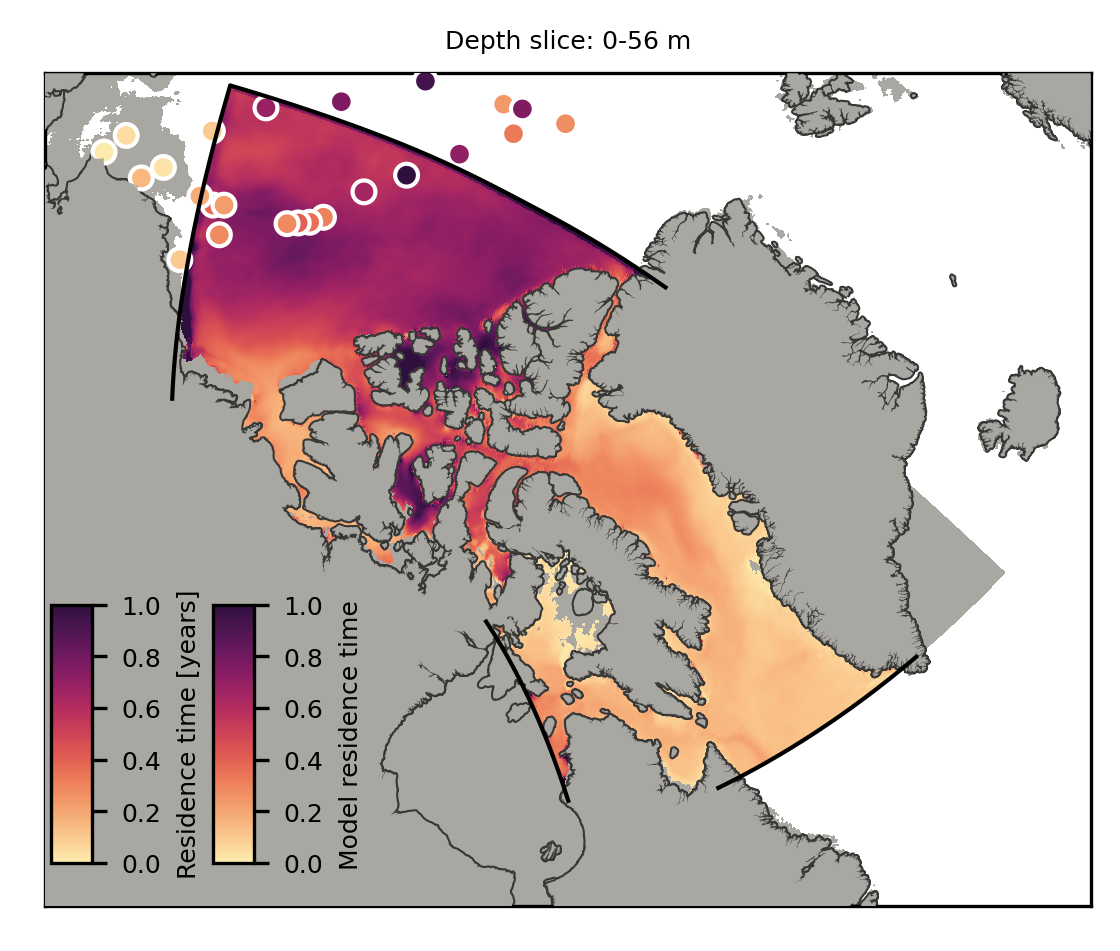

In [107]:
plot_residence_time(modelled_res_time1, depth_slice=(0,18), maxv=1, savefig=False, filename='residence_time_surface.png')

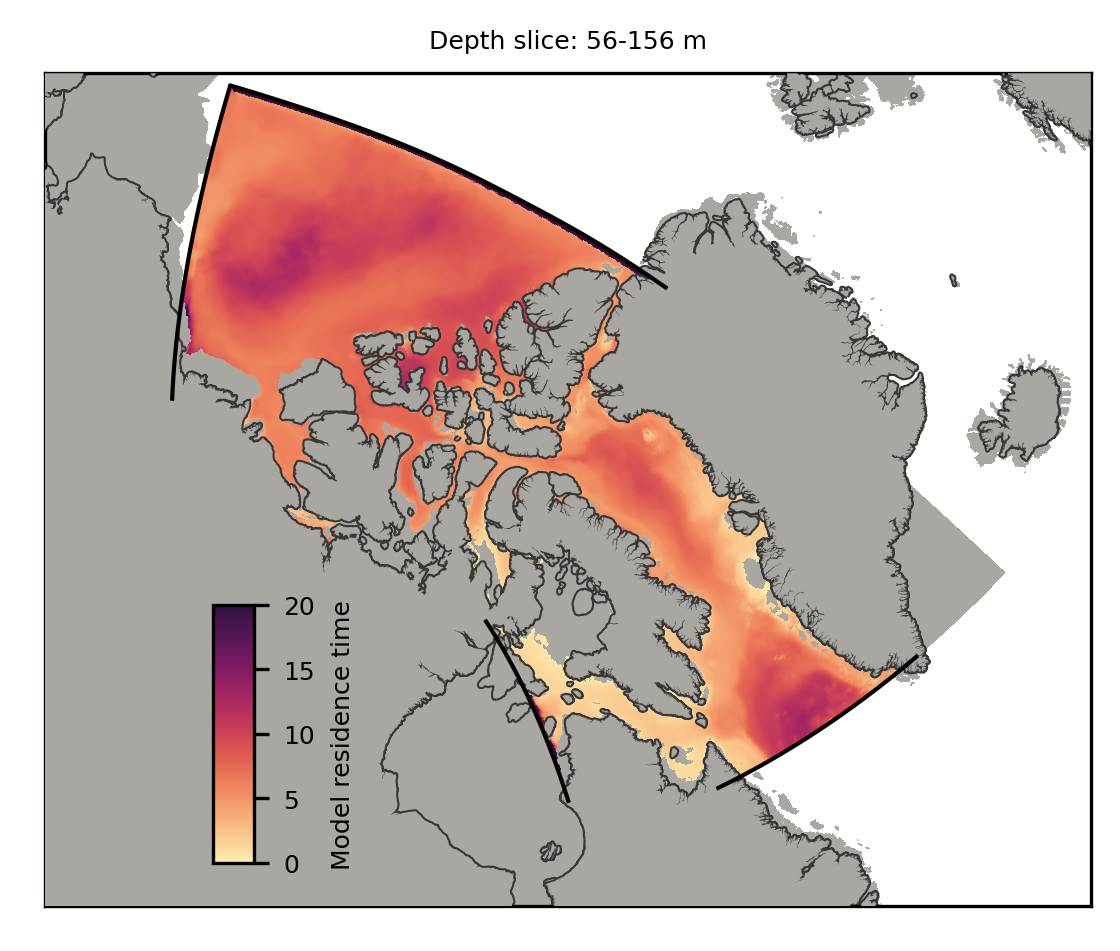

In [108]:
plot_residence_time(modelled_res_time1, depth_slice=(18,24), maxv=20, savefig=False, filename='residence_time_subsurface.png')

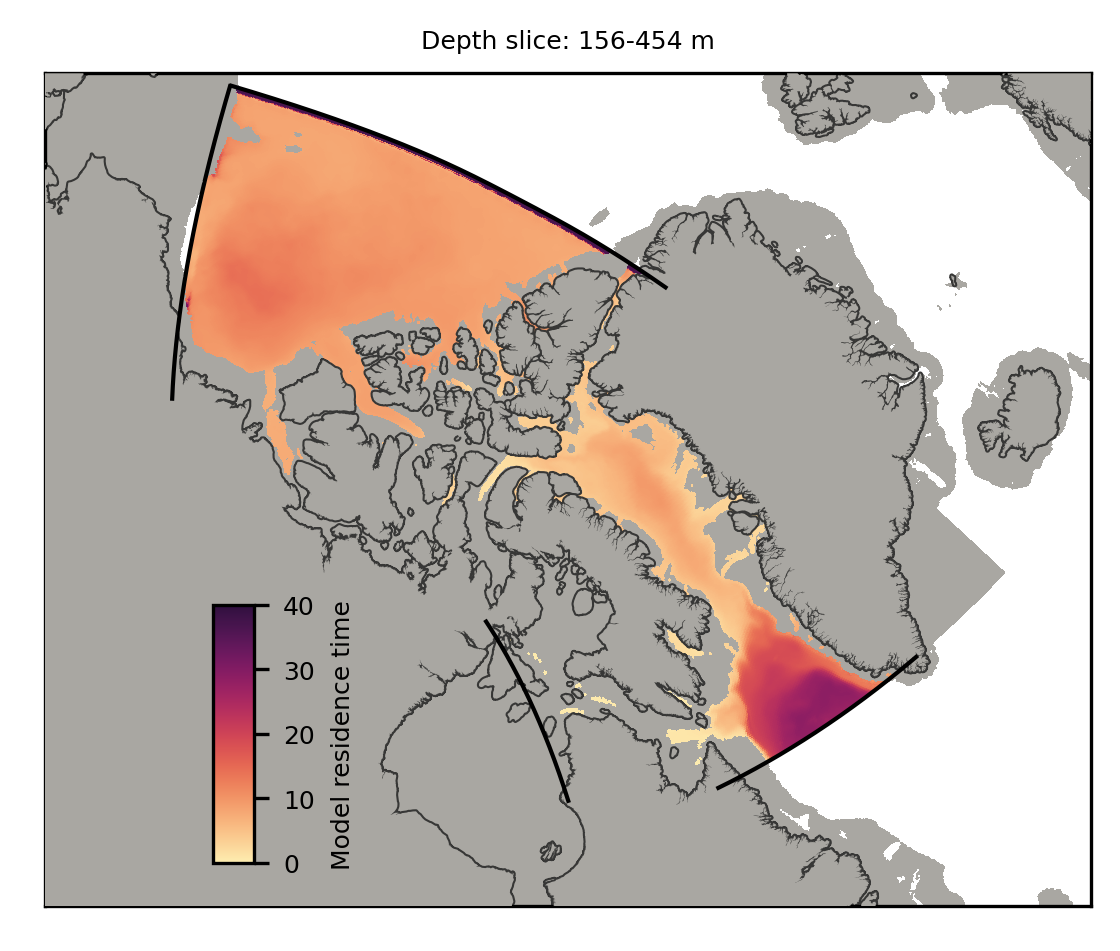

In [109]:
plot_residence_time(modelled_res_time1, depth_slice=(24,30), maxv=40)

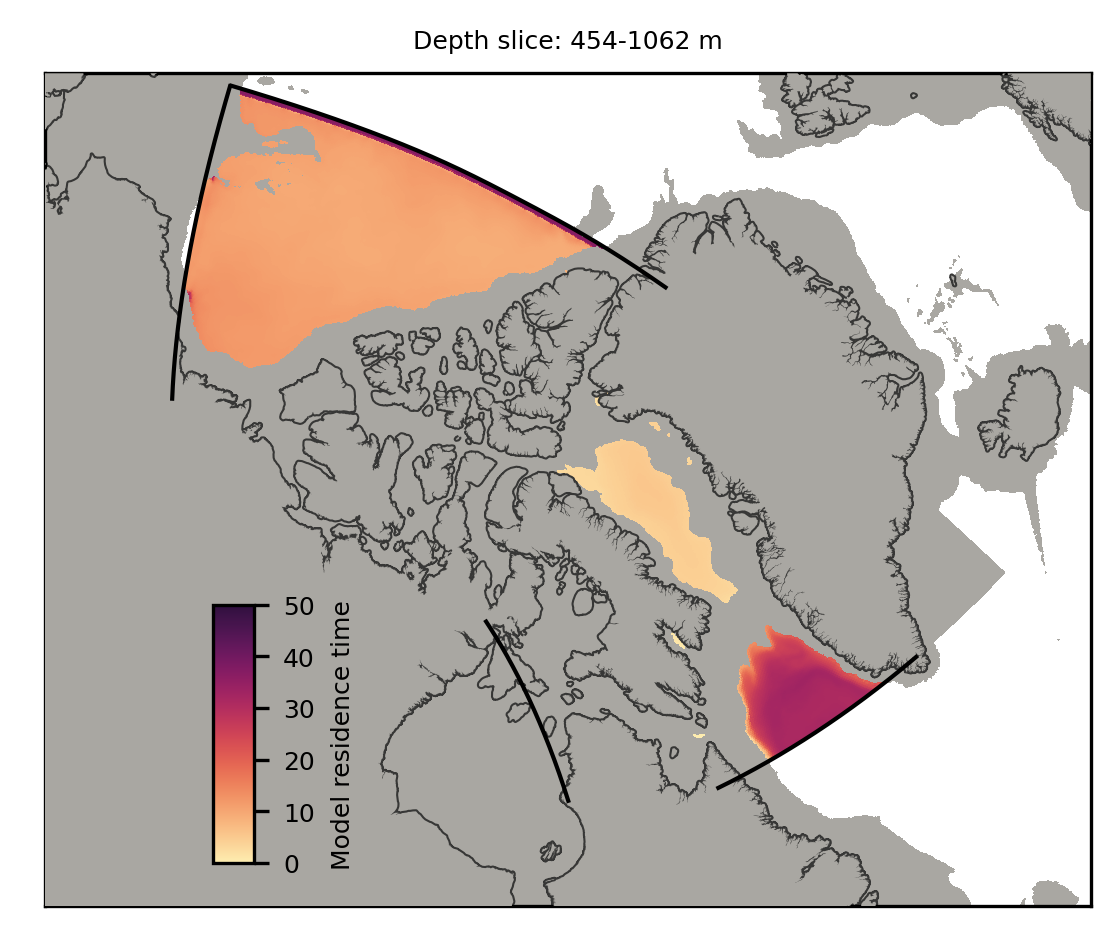

In [110]:
plot_residence_time(modelled_res_time1, depth_slice=(30,35), maxv=50, savefig=False, filename='residence_time_intermediate.png')

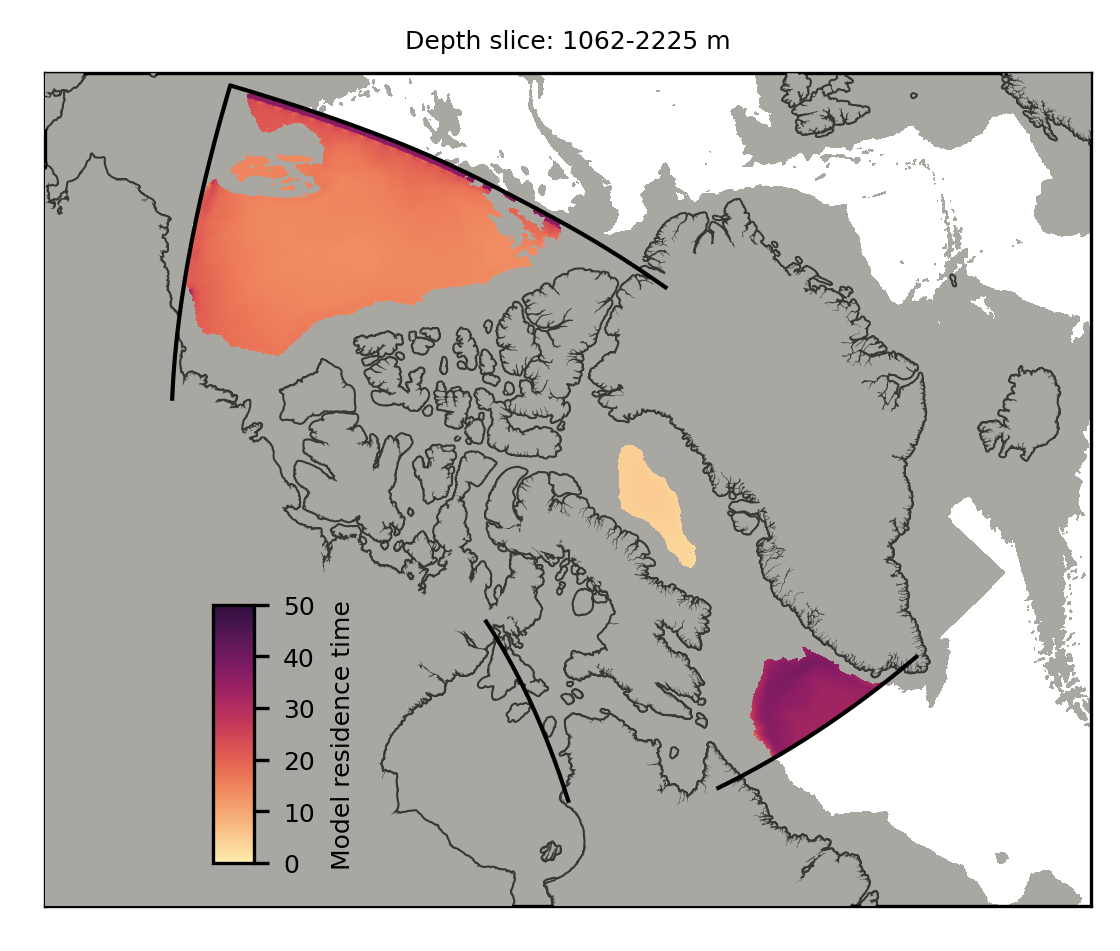

In [111]:
plot_residence_time(modelled_res_time1, depth_slice=(35,40), maxv=50, savefig=False, filename='residence_time_deep.png')

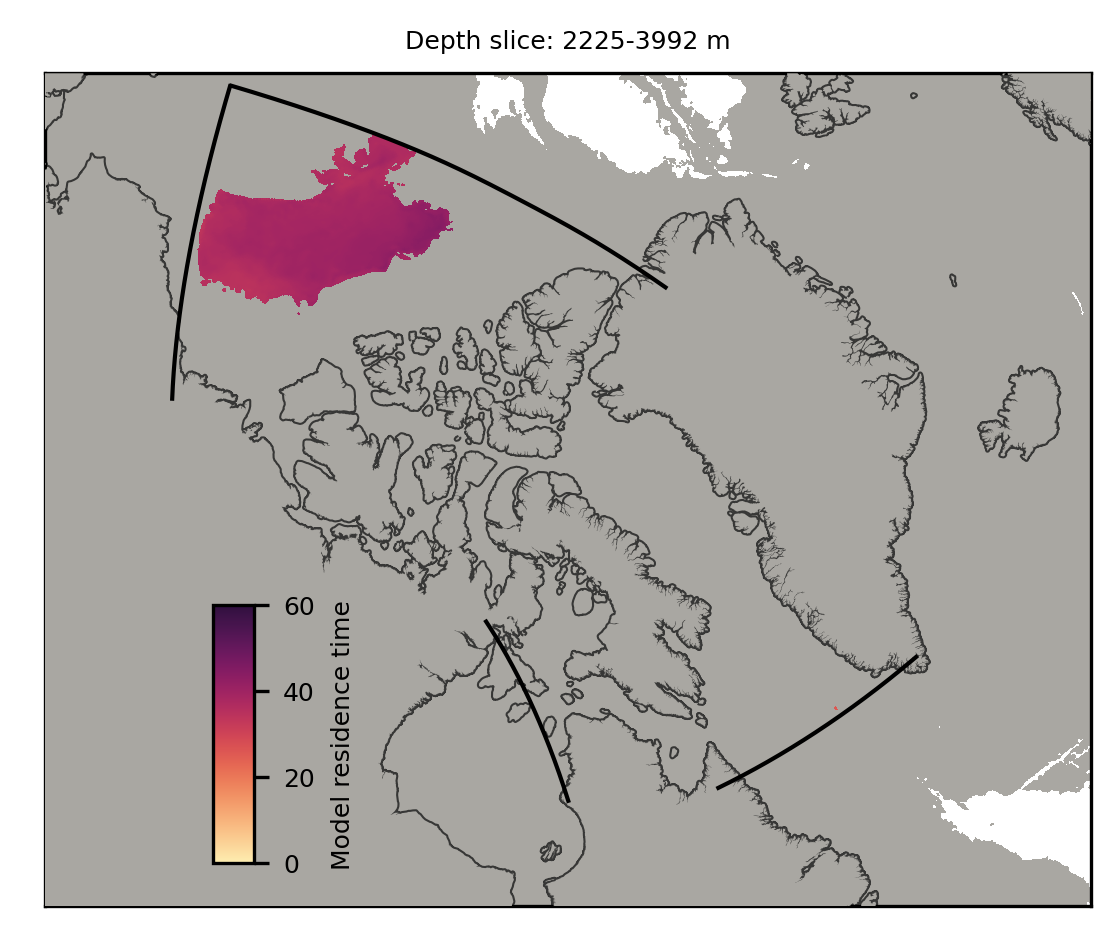

In [112]:
plot_residence_time(modelled_res_time1, depth_slice=(40,45), maxv=60)

In [113]:
modelled_res_time_ave1 = np.nanmean(modelled_res_time1[:,:,:],axis=(1,2))
modelled_res_time_ave2 = np.nanmean(modelled_res_time2[:,:,:],axis=(1,2))
modelled_res_time_ave3 = np.nanmean(modelled_res_time3[:,:,:],axis=(1,2))

# Bacon et al., 1976: Atlantic Ocean
Bacon_depth   = [300, 4880, 5003, 3820, 4940, 4950, 4440] # marked by top and bottom of range
Bacon_restime = [2.3, 20, 21, 54, 93, 90, 60]

# Henderson and Maier-Reimer, 2002: North Atlantic
HMR_depth   = [75, 2000]
HMR_restime = [3, 30] 

# Moore and Smith, 1986: 
MS_depth   = [200, 1770]
MS_restime = [5, 21] 

# Ones with only surface, intermediate or deep defined:
sid_depth = [5, 1500, 3000]
craig_restime   = [2, np.nan, 54]   # Craig et al., 1973; Pacific Ocean
nozaki_restime  = [1.7, 15, 100]    # Nozaki et al., 1976, 1990; Pacific Ocean
schaul_restime  = [1.6, np.nan, 50] # Schaule and Patterson, 1983; Sargasso Sea
schaul1_restime = [np.nan, 20, 80]  # Schaule and Patterson, 1981; North Pacific
shen_restime    = [2.5, np.nan, np.nan] # Shen and Boyle, 1988; Bermuda

In [114]:
color=['#00cc99', '#138484', '#0099ff', '#0d55ad', '#b6cce6', '#cc99cc', '#9966cc', '#5b3d7a', '#cdc4d7']

(5000.0, 0.0)

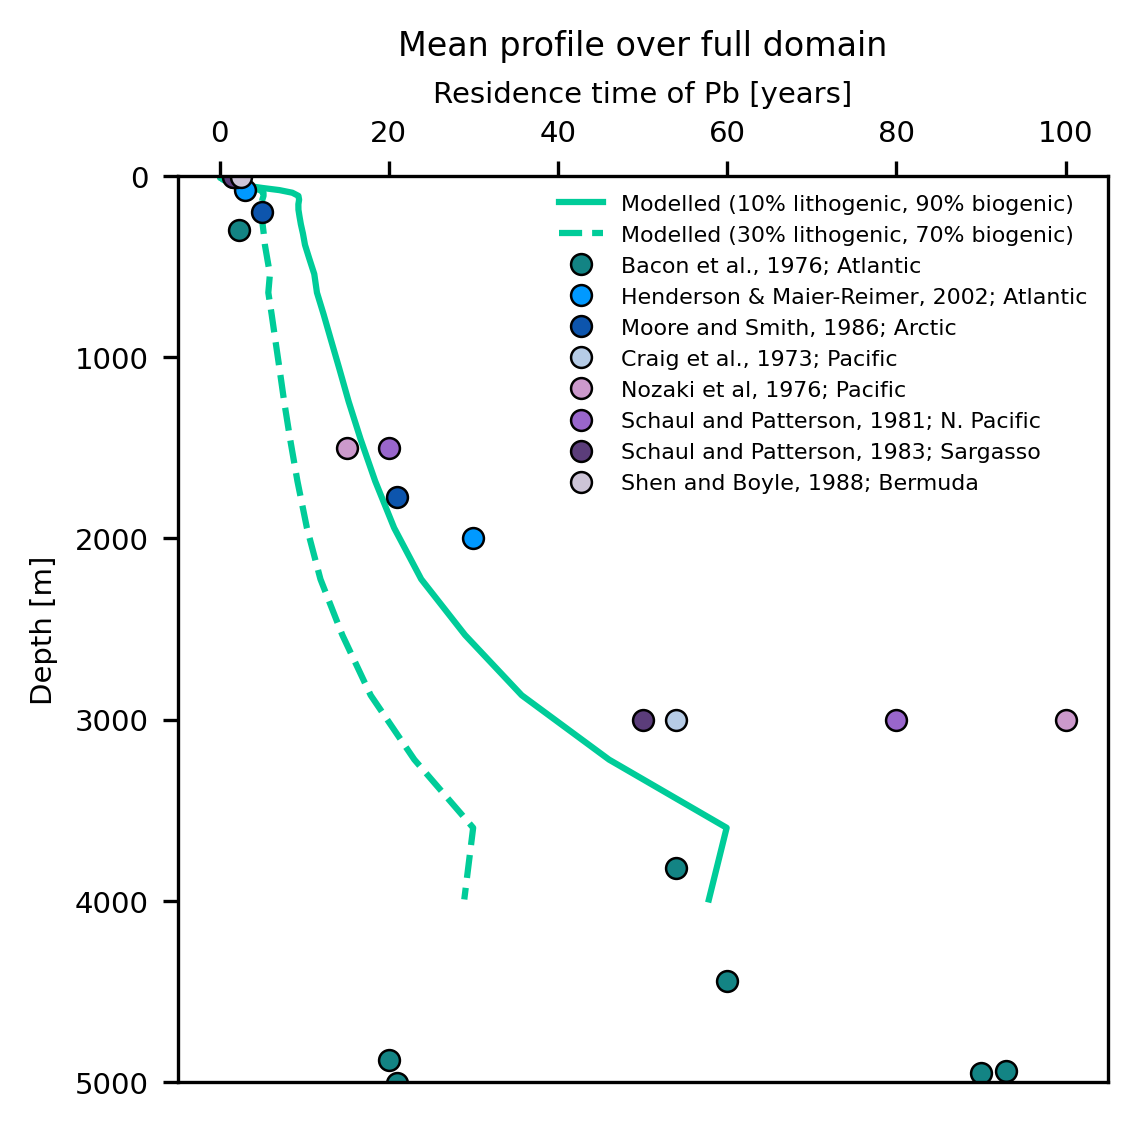

In [115]:
fig, ax = plt.subplots(1,1, figsize=(4.0,4.0), dpi=300)

# Model:
ax.plot(modelled_res_time_ave1, depths, c=color[0], label='Modelled (10% lithogenic, 90% biogenic)')
ax.plot(modelled_res_time_ave2, depths, '--', c=color[0], label='Modelled (30% lithogenic, 70% biogenic)')
# ax.plot(modelled_res_time_ave3, depths, '--', c=color[0], label='Modelled (30% lithogenic, 70% biogenic)')

# Observations:
ax.plot(Bacon_restime, Bacon_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[1], \
        label='Bacon et al., 1976; Atlantic', markersize=10)
ax.plot(HMR_restime, HMR_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[2], \
        label='Henderson & Maier-Reimer, 2002; Atlantic', markersize=10)
ax.plot(MS_restime, MS_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[3], \
        label='Moore and Smith, 1986; Arctic', markersize=10)
ax.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[4], \
        label='Craig et al., 1973; Pacific', markersize=10)
ax.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[5], \
        label='Nozaki et al, 1976; Pacific', markersize=10)
ax.plot(schaul1_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[6], \
        label='Schaul and Patterson, 1981; N. Pacific', markersize=10)
ax.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[7], \
        label='Schaul and Patterson, 1983; Sargasso', markersize=10)
ax.plot(shen_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[8], \
        label='Shen and Boyle, 1988; Bermuda', markersize=10)

# general settings:
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.tick_params(labelsize=7)
ax.set_xlabel('Residence time of Pb [years]', fontsize=7)
ax.set_ylabel('Depth [m]', fontsize=7)
ax.set_title('Mean profile over full domain',fontsize=8)
ax.legend(loc=(0.40, 0.64), fontsize=5.3, frameon=False)
ax.set_ylim(5000,0)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.png', bbox_inches='tight', dpi=300)

In [128]:
# # Station in CB
# # month=7
# i  = 608
# j  = 358
# di = 30
# dj = 30

# modelled_res_time_ave     = np.nanmean(modelled_res_time[:,i-di:i+di,j-dj:j+dj],axis=(1,2))
# normalized_biogenic_ave   = np.nanmean(normalized_biogenic[:,i-di:i+di,j-dj:j+dj],axis=(1,2))
# normalized_lithogenic_ave = np.nanmean(normalized_lithogenic[:,i-di:i+di,j-dj:j+dj],axis=(1,2))

In [ ]:
# file_range = ['ANHA4-EPM101_y2002m08d18_gridB.nc', 'ANHA4-EPM101_y2002m08d23_gridB.nc', 'ANHA4-EPM101_y2002m08d28_gridB.nc', \
#               'ANHA4-EPM101_y2002m09d02_gridB.nc', 'ANHA4-EPM101_y2002m09d07_gridB.nc', 'ANHA4-EPM101_y2002m09d12_gridB.nc', \
#               'ANHA4-EPM101_y2002m09d17_gridB.nc', 'ANHA4-EPM101_y2002m09d22_gridB.nc', 'ANHA4-EPM101_y2002m09d27_gridB.nc', \
#               'ANHA4-EPM101_y2002m10d02_gridB.nc', 'ANHA4-EPM101_y2002m10d07_gridB.nc']

# biomass_p = np.zeros((50,800,544))
# zflux_pop = np.zeros((50,800,544))
# for n,file in enumerate(file_range):
#     dset = xr.open_dataset(folder_EPM101+file)
#     # biomass concentration in phosphate units [mol P/m3]
#     biomass_p = biomass_p + dset['biomass_p'][0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
#     # vertical flux of particulate organic phosphate [mol P/m2/s]
#     zflux_pop = zflux_pop + dset['jp_pop'] [0,:,:,:].drop(labels=['time_centered', 'time_counter']).values
    
# biomass = biomass_p / n
# zflux   = zflux_pop / n 